# Build a Neural Search Service with Sentence Transformers and Qdrant

We’re building a Neural Search Service that uses SentenceTransformers to convert company descriptions into embeddings and Qdrant to store/index those vectors so users can query by meaning.

## Workflow

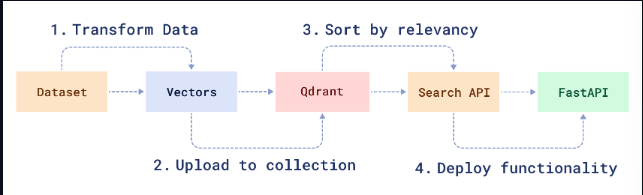

## Prepare sample dataset
To conduct a neural search on startup descriptions, you must first encode the description data into vectors. To process text, you can use a pre-trained models like BERT or sentence transformers. The sentence-transformers library lets you conveniently download and use many pre-trained models, such as DistilBERT, MPNet, etc.

Download the dataset : wget https://storage.googleapis.com/generall-shared-data/startups_demo.json

## Import the required modules 

In [7]:
from sentence_transformers import SentenceTransformer
import numpy as np
import json
import pandas as pd
from tqdm.notebook import tqdm

from qdrant_client import QdrantClient,models
from sentence_transformers import SentenceTransformer

## Download and create a pre-trained sentence encoder.

In [8]:
model = SentenceTransformer(
    "all-MiniLM-L6-v2", device="cpu"
)  # or device="cuda" if you  have a GPU

## Read the raw data file.

In [9]:
df = pd.read_json("./startups_demo.json", lines=True)


In [12]:
df = df.head(100)

Encode all startup descriptions to create an embedding vector for each. Internally, the encode function will split the input into batches, which will significantly speed up the process.

In [13]:
vectors = model.encode(
    [row.alt + ". " + row.description for row in df.itertuples()],
    show_progress_bar=True,
)

Batches: 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


In [15]:
vectors.shape # All of the descriptions are now converted into vectors.

(100, 384)

## Download the saved vectors into a new file named startup_vectors.npy

In [16]:
np.save("startup_vectors.npy", vectors, allow_pickle=False)

## Run Qdrant in Docker
Next, you need to manage all of your data using a vector engine. Qdrant lets you store, update or delete created vectors. Most importantly, it lets you search for the nearest vectors via a convenient API.

1. Download the Qdrant image from DockerHub.
    ```bash
    docker pull qdrant/qdrant
    ```

2. Start Qdrant inside of Docker.
    ```bash
    docker run -p 6333:6333 \
        -v $(pwd)/qdrant_storage:/qdrant/storage \
        qdrant/qdrant
    ```

Test the service by going to `http://localhost:6333/`. You should see the Qdrant version info in your browser.

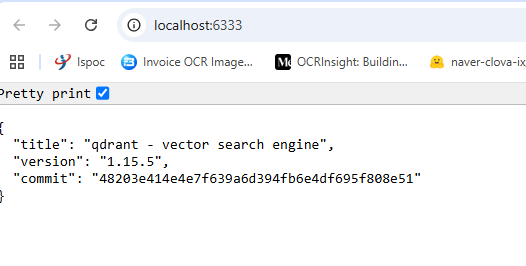

All data uploaded to Qdrant is saved inside the `./qdrant_storage` directory and will be persisted even if you recreate the container.

## Upload data to Qdrant

At this point, you should have startup records in the `startups_demo.json` file, encoded vectors in `startup_vectors.npy` and Qdrant running on a local machine.

Now you need to write a script to upload all startup data and vectors into the search engine.

In [17]:
# Import client library
from qdrant_client import QdrantClient
from qdrant_client.models import VectorParams, Distance

client = QdrantClient("http://localhost:6333")

### Related vectors need to be added to a collection. Create a new collection for your startup vectors.


In [19]:
if not client.collection_exists("startups"):
    client.create_collection(
        collection_name="startups",
        vectors_config=VectorParams(size=384, distance=Distance.COSINE),
    )

### Create an iterator over the startup data and vectors.
The Qdrant client library defines a special function that allows you to load datasets into the service. However, since there may be too much data to fit a single computer memory, the function takes an iterator over the data as input.

In [20]:
fd = open("./startups_demo.json")

# payload is now an iterator over startup data
payload = map(json.loads, fd)

# Load all vectors into memory, numpy array works as iterable for itself.
# Other option would be to use Mmap, if you don't want to load all data into RAM
vectors = np.load("./startup_vectors.npy")

## Upload the data

In [22]:
client.upload_collection(
    collection_name="startups",
    vectors=vectors,
    payload=payload,
    ids=None,  # Vector ids will be assigned automatically
    batch_size=256,  # How many vectors will be uploaded in a single request?
)

# Vectors are now uploaded to Qdrant.

## Build the search API

Now that all the preparations are complete, let’s start building a neural search class.

In order to process incoming requests, neural search will need 2 things: 
1) a model to convert the query into a vector and 
2) the Qdrant client to perform search queries.



## 1. Create a file named `neural_searcher.py` and specify the following.


In [23]:
from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer


class NeuralSearcher:
    def __init__(self, collection_name):
        self.collection_name = collection_name
        # Initialize encoder model
        self.model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
        # initialize Qdrant client
        self.qdrant_client = QdrantClient("http://localhost:6333")

## 2. Write the search function.

In [24]:
def search(self, text: str):
    # Convert text query into vector
    vector = self.model.encode(text).tolist()

    # Use `vector` for search for closest vectors in the collection
    search_result = self.qdrant_client.query_points(
        collection_name=self.collection_name,
        query=vector,
        query_filter=None,  # If you don't want any filters for now
        limit=5,  # 5 the most closest results is enough
    ).points
    # `search_result` contains found vector ids with similarity scores along with the stored payload
    # In this function you are interested in payload only
    payloads = [hit.payload for hit in search_result]
    return payloads

## 3. Add search filters.


```bash 
from qdrant_client.models import Filter
```

    ...

    city_of_interest = "Berlin"

    # Define a filter for cities
    city_filter = Filter(**{
        "must": [{
            "key": "city", # Store city information in a field of the same name 
            "match": { # This condition checks if payload field has the requested value
                "value": city_of_interest
            }
        }]
    })

    search_result = self.qdrant_client.query_points(
        collection_name=self.collection_name,
        query=vector,
        query_filter=city_filter,
        limit=5
    ).points
    ...

### You have now created a class for neural search queries. Now wrap it up into a service.



## Deploy the search with FastAPI

To build the service you will use the FastAPI framework.

1. Install FastAPI.
To install it, use the command

```bash
pip install fastapi uvicorn
```

2. Implement the service.

Create a file named `service.py` and specify the following.

The service will have only one API endpoint and will look like this:

In [ ]:
from fastapi import FastAPI

# The file where NeuralSearcher is stored
from neural_searcher import NeuralSearcher

app = FastAPI()

# Create a neural searcher instance
neural_searcher = NeuralSearcher(collection_name="startups")


@app.get("/api/search")
def search_startup(q: str):
    return {"result": neural_searcher.search(text=q)}


if __name__ == "__main__":
    import uvicorn

    uvicorn.run(app, host="0.0.0.0", port=8000)

## Using below code as we have notebook , otherwise we can use above code

In [ ]:
import nest_asyncio
from fastapi import FastAPI
from qdrant_client import QdrantClient
from sentence_transformers import SentenceTransformer
import uvicorn

# Fix for event loop conflict in Jupyter
nest_asyncio.apply()

# ----------------------------
# Neural Searcher Class
# ----------------------------
class NeuralSearcher:
    def __init__(self, collection_name):
        self.collection_name = collection_name
        self.model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
        self.qdrant_client = QdrantClient("http://localhost:6333")

    def search(self, text):
        # Step 1: Convert text query into vector embedding
        vector = self.model.encode(text).tolist()

        # Step 2: Query Qdrant collection
        search_result = self.qdrant_client.search(
            collection_name=self.collection_name,
            query_vector=vector,
            limit=5
        )

        # Step 3: Extract and return matching payloads
        results = [hit.payload for hit in search_result]
        return results


# ----------------------------
# FastAPI App
# ----------------------------
app = FastAPI()
neural_searcher = NeuralSearcher(collection_name="startups")

@app.get("/api/search")
def search_startup(q: str):
    return {"result": neural_searcher.search(q)}

# ----------------------------
# Run Server
# ----------------------------
if __name__ == "__main__":
    config = uvicorn.Config(app, host="0.0.0.0", port=8010, log_level="info")
    server = uvicorn.Server(config)
    import asyncio
    asyncio.run(server.serve())


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\copy.py:119: RuntimeWarning: coroutine 'Server.serve' was never awaited
  def deepcopy(x, memo=None, _nil=[]):
INFO:     Started server process [41232]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8010 (Press CTRL+C to quit)


INFO:     127.0.0.1:60293 - "GET /api/search?q=scout HTTP/1.1" 200 OK


C:\Users\abhishek.anand\AppData\Local\Temp\ipykernel_41232\3069102313.py:24: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = self.qdrant_client.search(


INFO:     127.0.0.1:57367 - "GET /api/search?q=healthcare HTTP/1.1" 200 OK
